# Advanced Optimization of the Model

Here we will update our compute options and perform a more advanced model with less assumptions (using the complete light curve and radial velocity curves).

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
logger = phoebe.logger('WARNING')
%matplotlib inline
phoebe.multiprocessing_on()

Import the PHOEBE bundle that we made in the last notebook:

In [24]:
b = phoebe.open('bundles/after_nm_fast.bundle')

# Update Physics

Now we will set a new set of compute options to compute models with more detailed physics

In [25]:
b.add_compute(compute='comp_phys')

<ParameterSet: 46 parameters | datasets: rv01, _default, lc01>

Now we add the fitting options to make the computations more detailed. 

In [26]:
b.set_value_all('ld_mode', value='interp')
b.set_value_all('atm', value='ck2004')
b.set_value('irrad_method', compute='comp_phys', value='horvat')
b.set_value_all('rv_method', compute='comp_phys', value='flux-weighted')
b.set_value_all('distortion_method', compute='comp_phys', value='roche')

Increase the number of triangles that cover the stellar surfaces (this provides higher resolution):

In [27]:
b['ntriangles@secondary@comp_phys']=2000

## Fitting with the Nelder Mead optimizer

Add a new solver with a new name (nm_phys) and tell it to use the new compute settings with more detailed physics: 

In [28]:
b.add_solver('optimizer.nelder_mead',  solver='nm_phys', compute='comp_phys', overwrite=True)

<ParameterSet: 14 parameters | qualifiers: continue_from, adaptive, compute, use_server, fatol, progress_every_niters, comments, priors_combine, fit_parameters, priors, maxiter, expose_lnprobabilities, initial_values, xatol>

Update the maximum number of iterations to 20 since the computations take so long:

In [29]:
b.set_value('maxiter', solver='nm_phys', value=20)

## Fit the light curve only with Nelder Mead optimizer

Since we're already quite close, we can first fit the light curve data. To do this, we will disable the radial velocity curve:

In [30]:
b.disable_dataset('rv01')

<ParameterSet: 20 parameters | components: binary, primary, secondary>

Select the parameters to be fitted. Right now, we only have the eclipses and so (when not fitting the radial velocities) we should not fit the eccentricity and argument of periastron (which have a large signature in the out-of-eclipse region):

In [31]:
fit_params = ['teffratio@binary', 'requivratio', 'requivsumfrac@binary']
b.set_value('fit_parameters@nm_phys', fit_params)

Run the solver:

In [32]:
b.run_solver(solver='nm_phys', compute='comp_phys', solution='nm_lc_sol_phys', overwrite=True)

100%|██████████| 20/20 [05:22<00:00, 16.12s/it]


<ParameterSet: 11 parameters | qualifiers: adopt_parameters, fitted_units, fitted_twigs, comments, adopt_values, success, niter, fitted_values, initial_values, adopt_distributions, message>

First take a look at the parameters without adopting them using "trial run":

In [33]:
print(b.adopt_solution('nm_lc_sol_phys', trial_run=True))

ParameterSet: 3 parameters
   teffratio@binary@orbit@comp...: 0.8818525570904059
   requivratio@binary@orbit@co...: 10.21829700664103
   requivsumfrac@binary@orbit@...: 0.09762611495901796


Adopt the solution:

In [34]:
b.adopt_solution('nm_lc_sol_phys')

<ParameterSet: 8 parameters | kinds: orbit, star>

Compute the model with the new solution and plot it to see what it looks like:

In [35]:
b.run_compute(compute='comp_phys', solution='nm_lc_sol_phys', sample_num=1, model='nm_lc_mod', overwrite=True)

Tue, 11 Jun 2024 21:53 BUNDLE       WARNING applying passed solution (nm_lc_sol_phys) to sample_from
Tue, 11 Jun 2024 21:53 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|██████████| 1/1 [00:41<00:00, 41.80s/it]


<ParameterSet: 9 parameters | qualifiers: times, samples, flux_scale, sampled_uniqueids, failed_samples, sampled_twigs, comments, sample_mode, fluxes>

Plot the model:

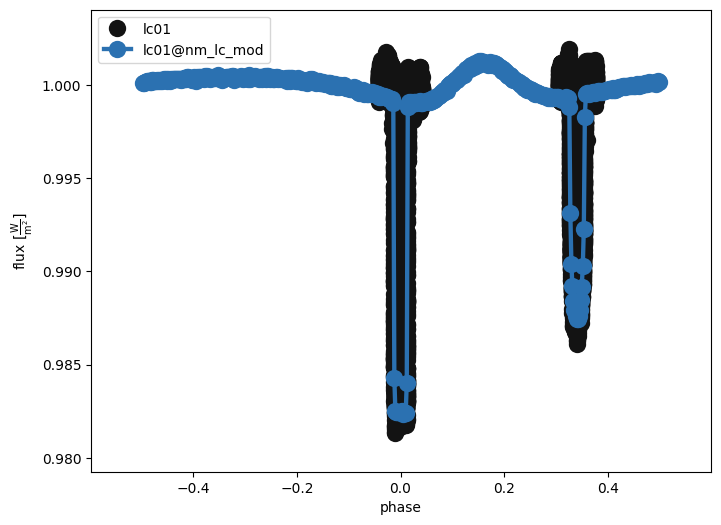

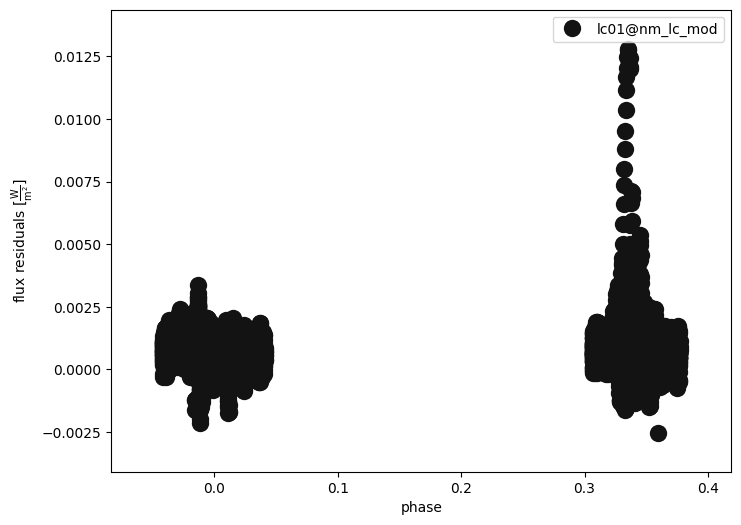

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [36]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o')

Now we can fit the inclination along with the tempearture ratio. It is important not to fit the radii and inclination together as they are strongly correlated and so could give extreme results)

In [37]:
fit_params = ['teffratio@binary', 'incl@binary']
b.set_value('fit_parameters@nm_phys', fit_params)

Now we can increase the number of phase points to better sample the light curve:

In [38]:
comp_phases = np.linspace(0,1,1001)
b.set_value('compute_phases', dataset='lc01', value=comp_phases)

Run the solver with the newly selected parameters and on the total light curve:

In [39]:
b.run_solver(solver='nm_phys', solution='nm_lc_sol_phys',compute='comp_phys', overwrite=True)

100%|██████████| 20/20 [11:41<00:00, 35.07s/it]


<ParameterSet: 11 parameters | qualifiers: adopt_parameters, fitted_units, fitted_twigs, comments, adopt_values, success, niter, fitted_values, initial_values, adopt_distributions, message>

First take a look at the parameters without adopting them using "trial run":

In [40]:
print(b.adopt_solution(solution='nm_lc_sol_phys', trial_run=True))

ParameterSet: 2 parameters
   teffratio@binary@orbit@comp...: 0.8826868712738906
      incl@binary@orbit@component: 90.96394260748343 deg


Adopt the solution:

In [41]:
b.adopt_solution('nm_lc_sol_phys')

<ParameterSet: 18 parameters | kinds: orbit, star>

Compute the model and plot it:

In [42]:
b.run_compute(compute='comp_phys', solution='nm_lc_sol_phys', model='nm_lc_mod', overwrite=True)

Tue, 11 Jun 2024 22:06 BUNDLE       WARNING applying passed solution (nm_lc_sol_phys) to sample_from
Tue, 11 Jun 2024 22:06 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_lc_sol_phys=False
Tue, 11 Jun 2024 22:06 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|██████████| 1/1 [01:05<00:00, 65.74s/it]


<ParameterSet: 9 parameters | qualifiers: times, samples, flux_scale, sampled_uniqueids, failed_samples, sampled_twigs, comments, sample_mode, fluxes>

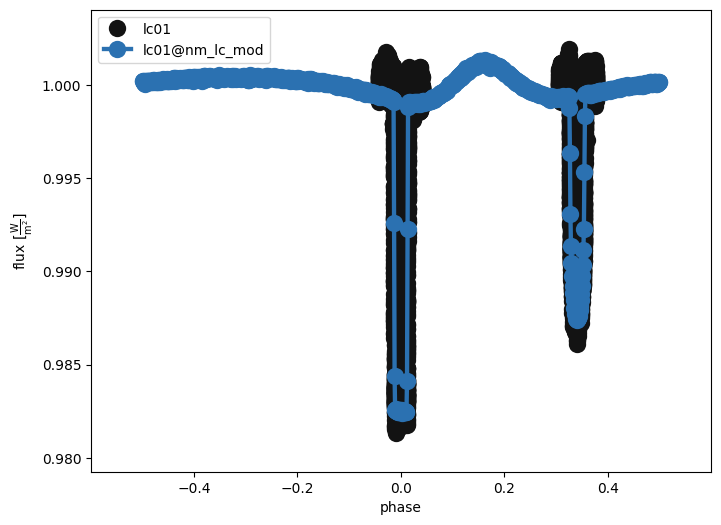

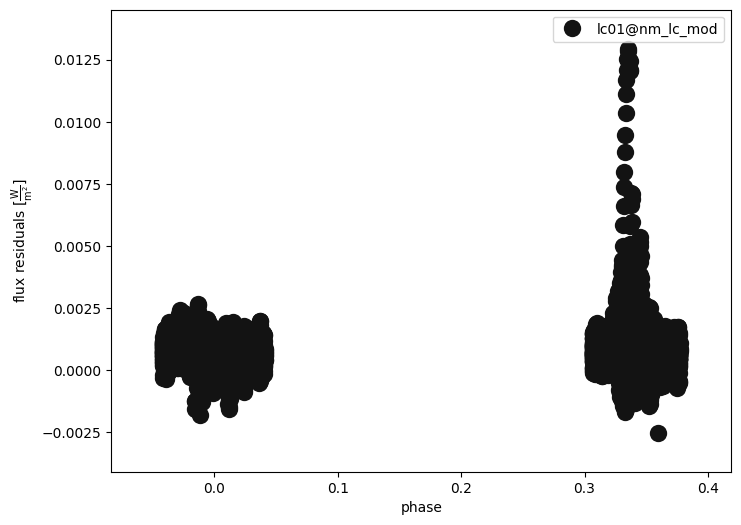

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [43]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o')

Plot the residuals for each eclipse:

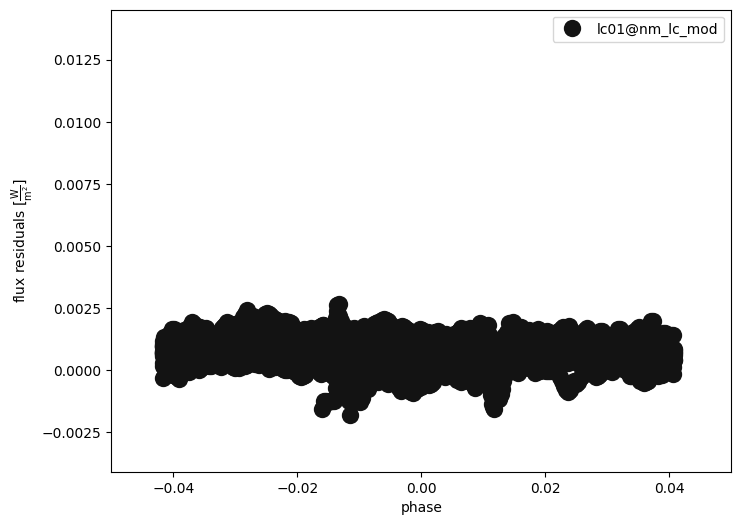

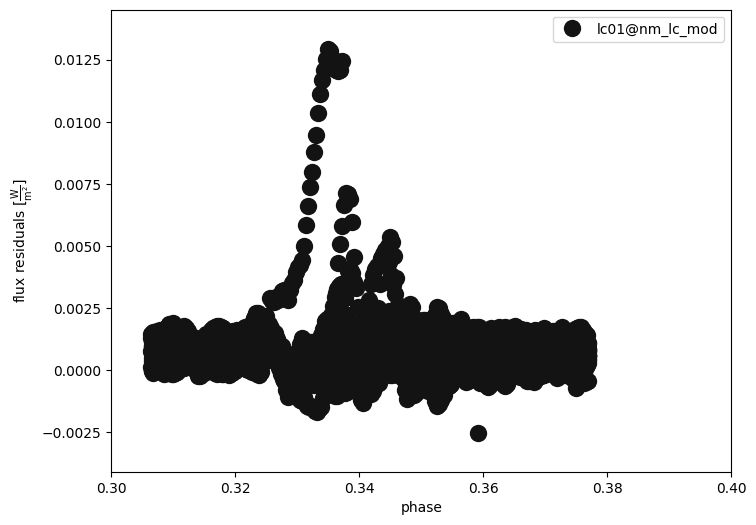

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [44]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, xlim=(-0.05,0.05), legend=True, marker = 'o')
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, xlim=(0.3,0.4), legend=True, marker = 'o')

Now let's look at the full light curve:

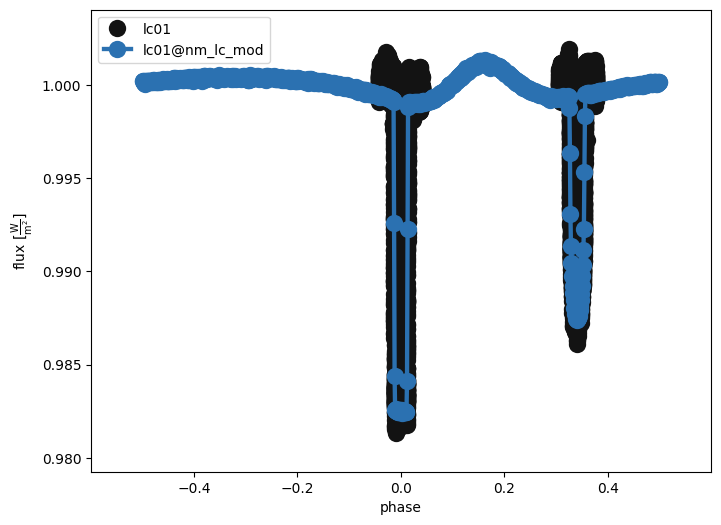

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [45]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o')

Save the bundle before we proceed:

In [46]:
b.save('bundles/during_nm_phys.bundle')

'bundles/during_nm_phys.bundle'

In [47]:
b = phoebe.load('bundles/during_nm_phys.bundle')

Now let's include the radial velocity data and fit both together (the full light curve and radail velocities):

In [48]:
b.enable_dataset('rv01')

<ParameterSet: 20 parameters | components: binary, primary, secondary>

We can now fit parameters that are relevant to both the rv and the light curve:

In [49]:
fit_params =['vgamma@system', 'q@binary', 'asini@binary','ecc@binary', 'per0@binary','teffratio@binary', 'requivratio', 'requivsumfrac@binary']
b.set_value('fit_parameters@nm_phys', fit_params)

Let's run the solver:

In [50]:
b.run_solver(solver='nm_phys', solution='nm_sol_phys2', overwrite=True)

Tue, 11 Jun 2024 22:07 BUNDLE       WARNING fit_parameters contains a parameter (['per0']) that affects phasing which could cause issues with mask_phases
100%|██████████| 20/20 [11:13<00:00, 33.69s/it]


<ParameterSet: 11 parameters | qualifiers: adopt_parameters, fitted_units, fitted_twigs, comments, adopt_values, success, niter, fitted_values, initial_values, adopt_distributions, message>

Check the solution:

In [51]:
print(b.adopt_solution(solution='nm_sol_phys2', trial_run=True))

ParameterSet: 8 parameters
                    vgamma@system: 16.051091139743384 km / s
         q@binary@orbit@component: 1.6115278328981435
     asini@binary@orbit@component: 86.99237467413607 solRad
       ecc@binary@orbit@component: 0.2571302441897245
      per0@binary@orbit@component: 168.32409539433206 deg
   teffratio@binary@orbit@comp...: 0.8826868712738906
   requivratio@binary@orbit@co...: 10.21829700664103
   requivsumfrac@binary@orbit@...: 0.09762611495901796


Adopt the solution:

In [52]:
b.adopt_solution('nm_sol_phys2')

<ParameterSet: 8 parameters | contexts: system, component>

And compute the model:

In [53]:
b.run_compute(compute='comp_phys', solution='nm_sol_phys2', model='nm_phys_mod2', sample_num=1,overwrite=True)


Tue, 11 Jun 2024 22:19 BUNDLE       WARNING applying passed solution (nm_sol_phys2) to sample_from
Tue, 11 Jun 2024 22:19 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|██████████| 1/1 [01:12<00:00, 72.93s/it]


<ParameterSet: 13 parameters | kinds: lc, rv>

Now let's plot the light and radial velocity curves:

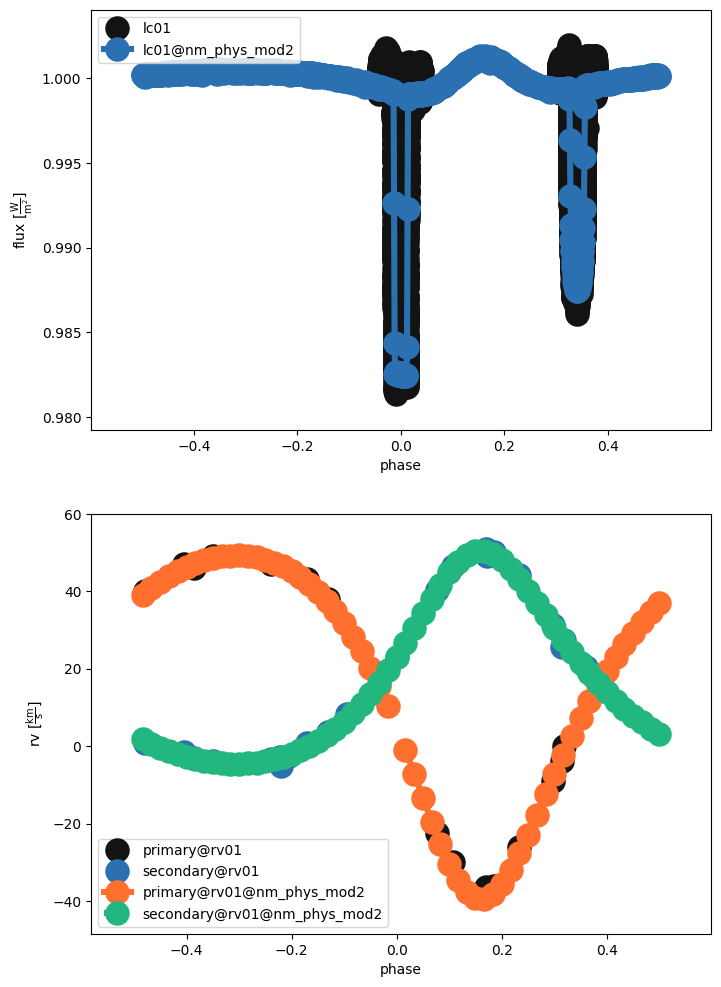

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 800x1200 with 2 Axes>)

In [54]:
b.plot(model='nm_phys_mod2', x='phases', show=True, legend=True, marker = 'o')

Let's plot the eclipses and residuals:

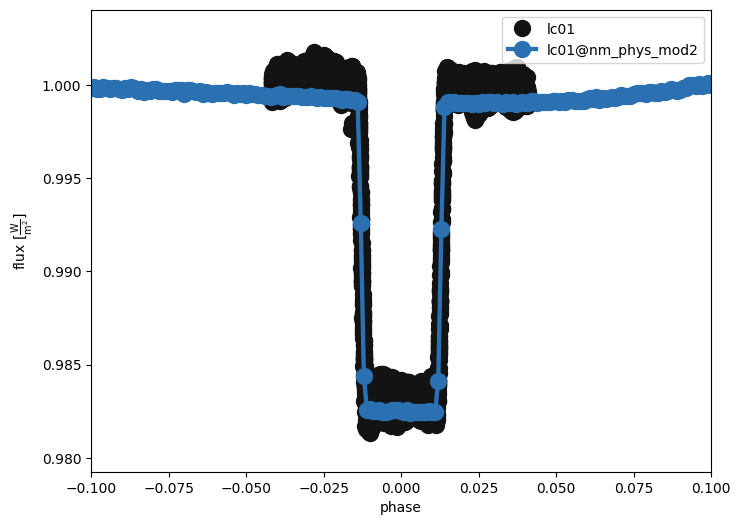

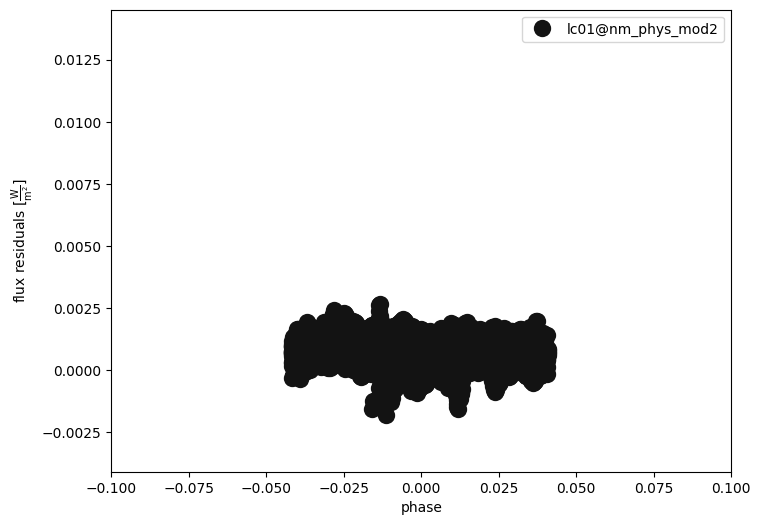

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [55]:
b.plot(kind='lc', model='nm_phys_mod2', x='phases', show=True, legend=True, marker = 'o',xlim=(-0.1,0.1))
b.plot(kind='lc', model='nm_phys_mod2', x='phases', y='residuals', show=True, legend=True, marker = 'o',xlim=(-0.1,0.1))

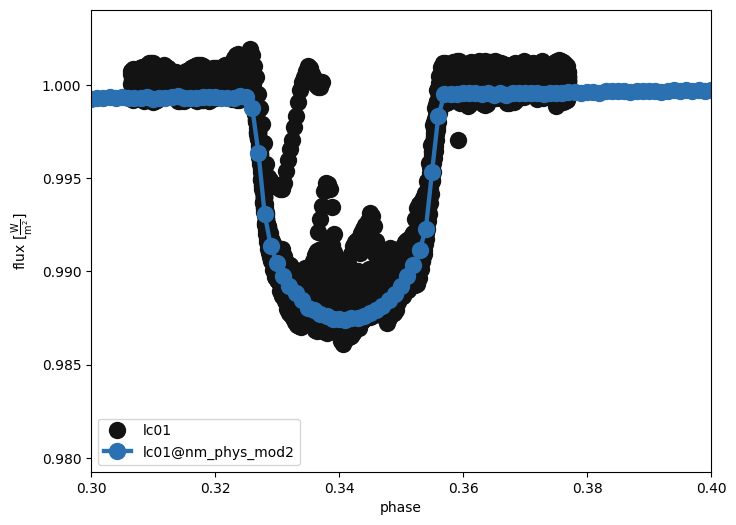

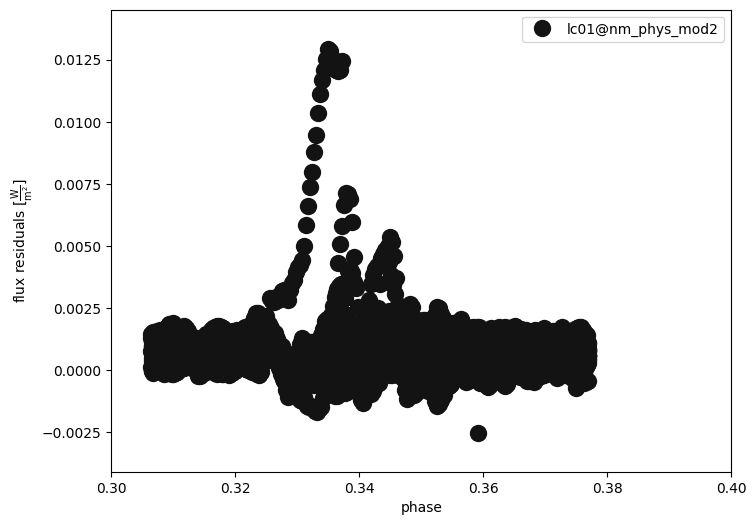

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [56]:
b.plot(kind='lc', model='nm_phys_mod2', x='phases', show=True, legend=True, marker = 'o',xlim=(0.3,0.4))
b.plot(kind='lc', model='nm_phys_mod2', x='phases', y='residuals', show=True, legend=True, marker = 'o',xlim=(0.3,0.4))

To further improve the eclipse depth fits, we can fit just the ratio of the radii and effective temperature:

In [57]:
fit_params = ['teffratio@binary', 'requivratio@binary']
b.set_value('fit_parameters@nm_phys', fit_params)

Now let's run the solver (this should be a little faster given the smaller number of fitted parameters)

In [58]:
b.run_solver(solver='nm_phys', solution='nm_sol_phys3', overwrite=True)

100%|██████████| 20/20 [11:00<00:00, 33.01s/it]


<ParameterSet: 11 parameters | qualifiers: adopt_parameters, fitted_units, fitted_twigs, comments, adopt_values, success, niter, fitted_values, initial_values, adopt_distributions, message>

Let's adopt the solution:

In [59]:
print(b.adopt_solution(solution='nm_sol_phys3'))

ParameterSet: 7 parameters
       teffratio@binary@component: 0.8834910388002577
     requivratio@binary@component: 10.186086610817647
C          teff@primary@component: 5706.905648807504 K
C      requiv@secondary@component: 7.734599764387347 solRad
C        requiv@primary@component: 0.7593298643438968 solRad
C        logg@secondary@component: 2.794670403024242
C          logg@primary@component: 4.603447321554712


And compute the model:

In [60]:
b.run_compute(compute='comp_phys', solution='nm_sol_phys3', model='nm_phys_mod3', sample_num=1,overwrite=True)

Tue, 11 Jun 2024 22:31 BUNDLE       WARNING applying passed solution (nm_sol_phys3) to sample_from
Tue, 11 Jun 2024 22:31 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|██████████| 1/1 [01:10<00:00, 70.11s/it]


<ParameterSet: 13 parameters | kinds: lc, rv>

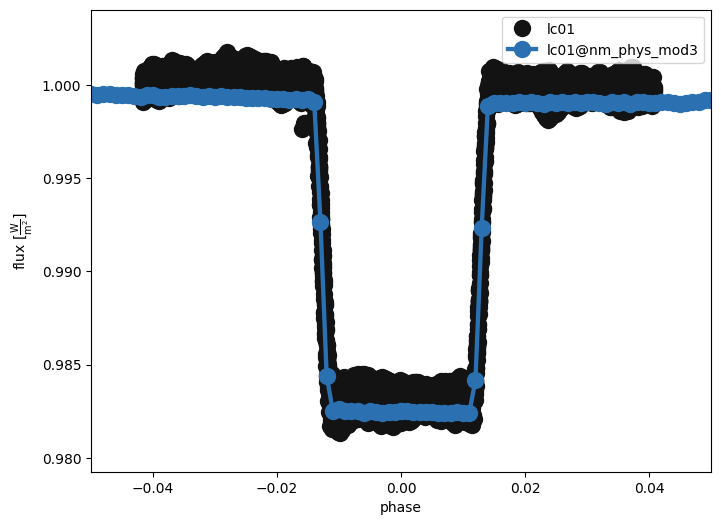

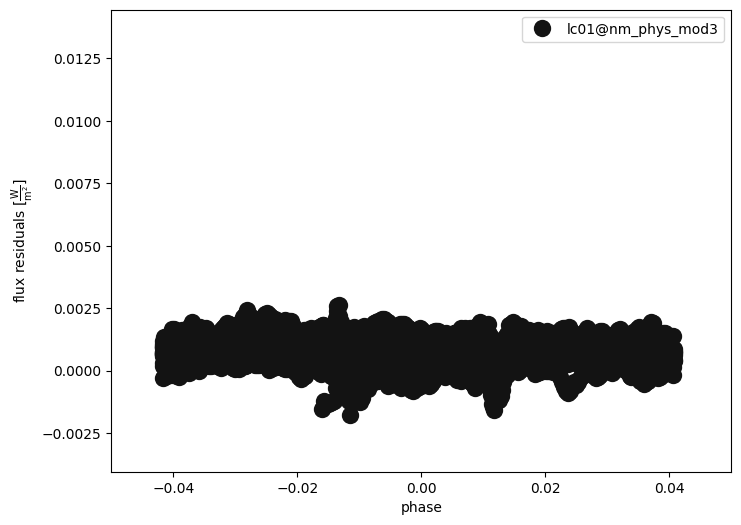

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [61]:
b.plot(kind='lc', model='nm_phys_mod3', x='phases', show=True, legend=True, marker = 'o',xlim=(-0.05,0.05))
b.plot(kind='lc', model='nm_phys_mod3', x='phases', y='residuals', show=True, legend=True, marker = 'o',xlim=(-0.05,0.05))

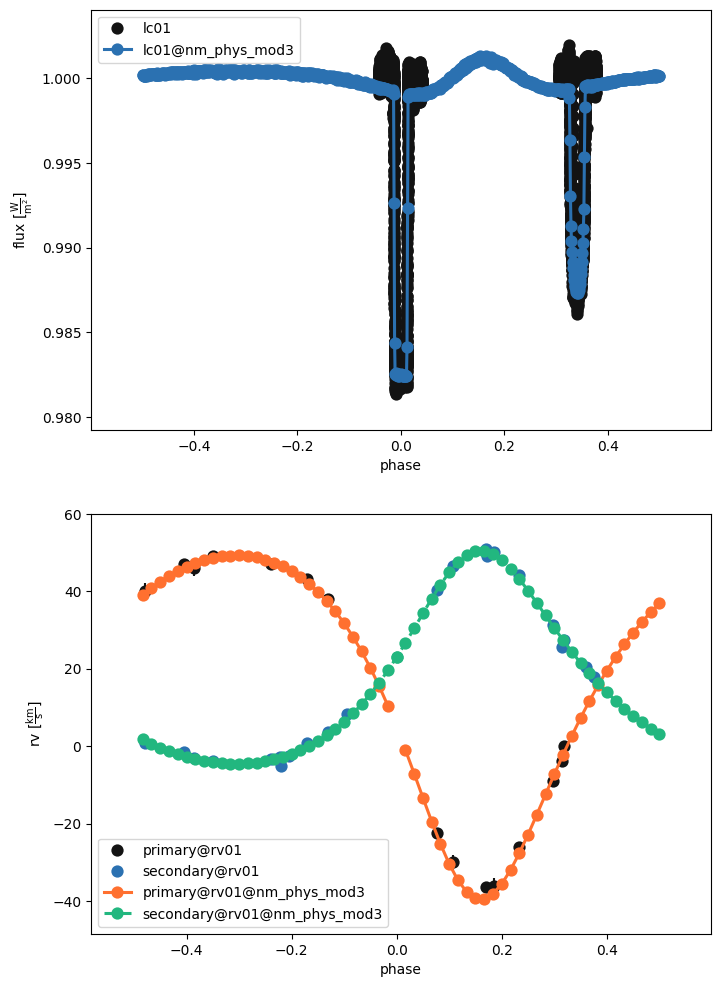

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 800x1200 with 2 Axes>)

In [62]:
b.plot(model='nm_phys_mod3',s=0.01, x='phases', show=True, legend=True, marker = 'o')

In [63]:
b.save('bundles/during_nm_phys.bundle')

'bundles/during_nm_phys.bundle'

In [64]:
fit_params = ['teffratio@binary', 'incl@binary','ecc@binary', 'per0@binary']
b.set_value('fit_parameters@nm_phys', fit_params)

In [65]:
b.run_solver(solver='nm_phys', solution='nm_sol_phys4', overwrite=True)

Tue, 11 Jun 2024 22:32 BUNDLE       WARNING fit_parameters contains a parameter (['per0']) that affects phasing which could cause issues with mask_phases
100%|██████████| 20/20 [10:31<00:00, 31.56s/it]


<ParameterSet: 11 parameters | qualifiers: adopt_parameters, fitted_units, fitted_twigs, comments, adopt_values, success, niter, fitted_values, initial_values, adopt_distributions, message>

In [66]:
print(b.adopt_solution(solution='nm_sol_phys4', trial_run=True))

ParameterSet: 4 parameters
   teffratio@binary@orbit@comp...: 0.8834910388002577
      incl@binary@orbit@component: 90.96394260748343 deg
       ecc@binary@orbit@component: 0.2571302441897245
      per0@binary@orbit@component: 168.32409539433206 deg


In [67]:
b.adopt_solution(solution='nm_sol_phys4')

<ParameterSet: 4 parameters | qualifiers: incl, ecc, per0, teffratio>

In [68]:
b.run_compute(compute='comp_phys', solution='nm_sol_phys4', model='nm_phys_mod4', sample_num=1,overwrite=True)

Tue, 11 Jun 2024 22:43 BUNDLE       WARNING applying passed solution (nm_sol_phys4) to sample_from
Tue, 11 Jun 2024 22:43 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|██████████| 1/1 [01:06<00:00, 66.62s/it]


<ParameterSet: 13 parameters | kinds: lc, rv>

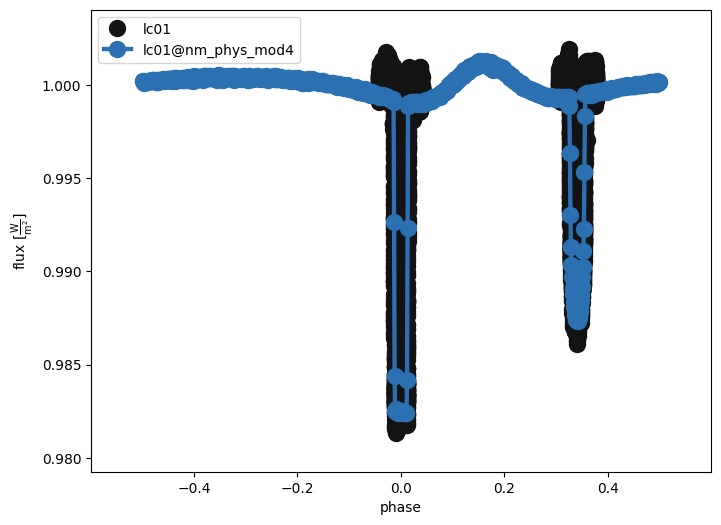

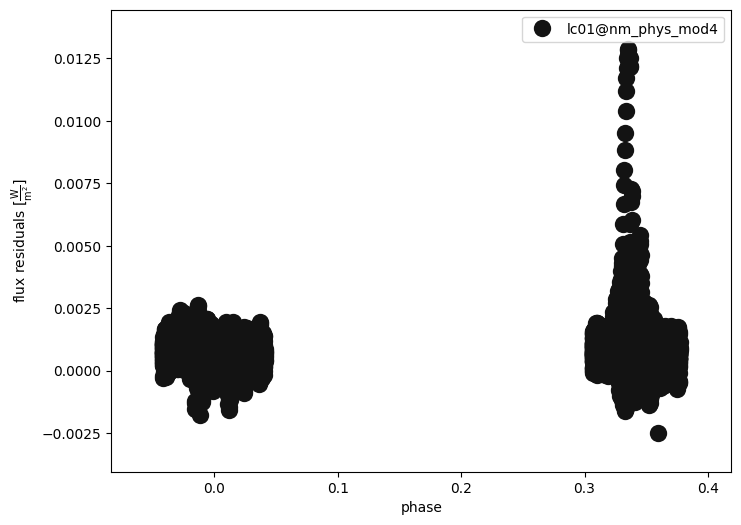

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [69]:
b.plot(kind='lc', model='nm_phys_mod4', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='nm_phys_mod4', x='phases', y='residuals', show=True, legend=True, marker = 'o')

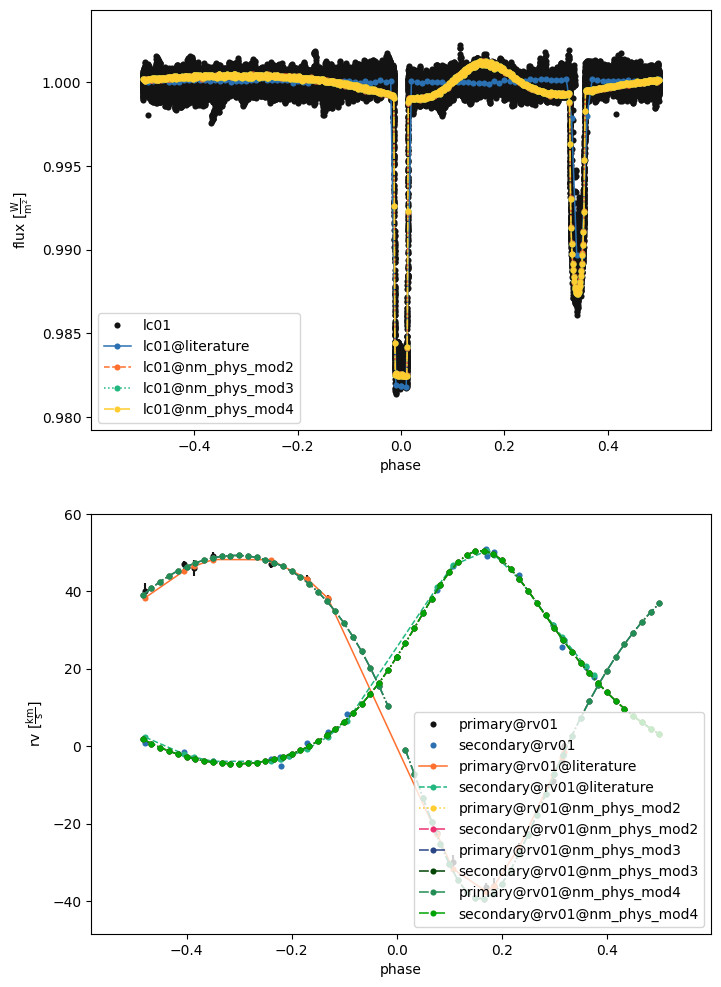

(<autofig.figure.Figure | 2 axes | 15 call(s)>,
 <Figure size 800x1200 with 2 Axes>)

In [75]:
b.plot(model=['literature','nm_phys_mod','nm_phys_mod2','nm_phys_mod3','nm_phys_mod4'],x='phases',s=0.005, show=True, legend=True, marker = 'o')

In [71]:
b.set_value('mask_enabled@lc01', False)

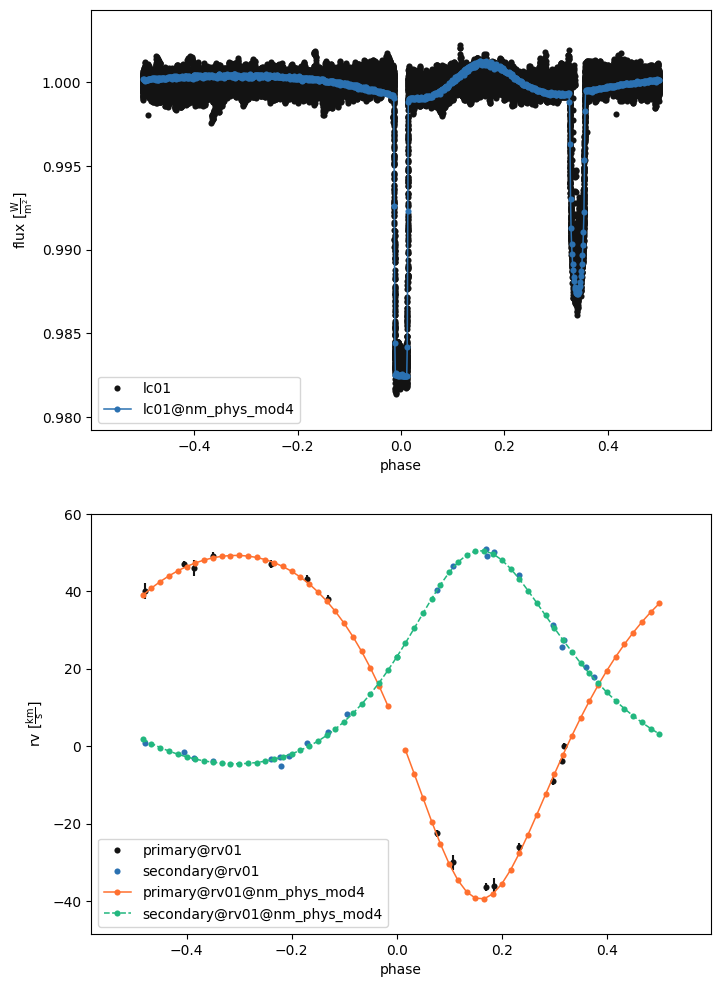

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 800x1200 with 2 Axes>)

In [76]:
b.plot(model=['nm_phys_mod4'],x='phases',s=0.005, show=True, legend=True, marker = 'o')

While we can see that there are variations in the out-of-eclipse model that are not in the light curve, these data are heavily detrended and so we have likely removed this feature. The next step, is thus to take the original data and detrend it in a less agressive way so that the GPs can fit the additional trends (in this case, spots).

In [72]:
b.save('bundles/after_nm_phys.bundle')

'bundles/after_nm_phys.bundle'